## Part I: Analytical Option Formulae

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq,fsolve
from scipy import interpolate
from scipy.optimize import least_squares
import os
import datetime as dt

In [27]:
# 1. Option valuation with Black-Scholes Model
def BlackScholesCall(S,K,r,sigma,T):
    d1=(np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S,K,r,sigma,T):
    d1=(np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

# 2. Option valuation with Bachelier Model
def BachelierCall(S,K,sigma,T):
    d=(S-K) / (S*sigma*np.sqrt(T))
    return (S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d)

def BachelierPut(S,K,sigma,T):
    d=(S-K) / (S*sigma*np.sqrt(T))
    return (K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d)

# 3. Option valuation with Black76 Model
def Black76Call(F,K,r,sigma,T):
    d1=(np.log(F/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return np.exp(-r*T) * (F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F,K,r,sigma,T):
    d1=(np.log(F/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return np.exp(-r*T) * (K*norm.cdf(-d2) - F*norm.cdf(-d1))

# 4. Option valuation with Displaced Diffusion Model
def DDCall(F,K,r,sigma,T,beta):
    d1=(np.log(F/(beta*(K+(1-beta)/beta*F)))+(beta**2)*(sigma**2)*T/2) / (beta*sigma*np.sqrt(T))
    d2=d1-beta*sigma*np.sqrt(T)
    return np.exp(-r*T) * (F/beta*norm.cdf(d1) - (K+(1-beta)/beta*F)*norm.cdf(d2))

def DDPut(F,K,r,sigma,T,beta):
    d1=(np.log(F/(beta*(K+(1-beta)/beta*F)))+(beta**2)*(sigma**2)*T/2) / (beta*sigma*np.sqrt(T))
    d2=d1-beta*sigma*np.sqrt(T)
    return np.exp(-r*T) * ((K+(1-beta)/beta*F)*norm.cdf(-d2) - F/beta*norm.cdf(-d1))

## Part II: Model Calibration

In [28]:
# process data
S=846.9  # GOOG price on 20130830
os.chdir(r'C:\Users\katya\Desktop\PythonCode总结\StochasticModelling')

call_df=pd.read_csv(r'goog_call.csv')
call_df['mid price']=(call_df['best_bid']+call_df['best_offer'])/2
call_df=call_df[call_df['strike']>S]  # only keep out-of-the-money option
put_df=pd.read_csv(r'goog_put.csv')
put_df['mid price']=(put_df['best_bid']+put_df['best_offer'])/2
put_df=put_df[put_df['strike']<S]  # only keep out-of-the-money option
mkt_df = pd.concat([put_df, call_df])
print(mkt_df.head())

# generate r
rate_df=pd.read_csv(r'discount.csv')
today=dt.date(2013,8,30)
expiry=dt.date(2015,1,17)
T=(expiry-today).days / 365.0
func=interpolate.interp1d(rate_df['Day'],rate_df['Rate (%)'])
r=func(T*365)/100
F=S*np.exp(r*T)

       date    expiry  strike  best_bid  best_offer  mid price
0  20130830  20150117   320.0      0.90        2.00      1.450
1  20130830  20150117   340.0      0.15        2.30      1.225
2  20130830  20150117   350.0      0.80        2.45      1.625
3  20130830  20150117   360.0      0.60        2.65      1.625
4  20130830  20150117   370.0      0.65        2.85      1.750


In [29]:
# Implied volatility with Black-Scholes Model, i.e. market volatility
def impliedCallVolatility(S,K,r,price,T):
    return brentq(lambda x: price - BlackScholesCall(S,K,r,x,T),-1,1)
def impliedPutVolatility(S,K,r,price,T):
    return brentq(lambda x: price - BlackScholesPut(S,K,r,x,T),-1,1)
# can use fsolve as well
# return fsolve(lambda x: price - BlackScholesCall(S,K,r,x,T),0.5)

ATMprice=float(mkt_df[mkt_df['strike']==850]['mid price'])
ATMimpliedvol=impliedCallVolatility(S,850,r,ATMprice,T)
print('ATMimpliedvol: %.4f' %ATMimpliedvol)

mkt_df['implied vol']=np.nan
for i in range(mkt_df.shape[0]):
    if mkt_df['strike'][i]<S:
        mkt_df['implied vol'][i]=impliedPutVolatility(S,mkt_df['strike'][i],r,
                                                     mkt_df['mid price'][i],T)
    else:
        mkt_df['implied vol'][i]=impliedCallVolatility(S,mkt_df['strike'][i],r,
                                                     mkt_df['mid price'][i],T)
        
print(mkt_df.head())

ATMimpliedvol: 0.2543


C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


       date    expiry  strike  best_bid  best_offer  mid price  implied vol
0  20130830  20150117   320.0      0.90        2.00      1.450     0.393102
1  20130830  20150117   340.0      0.15        2.30      1.225     0.361520
2  20130830  20150117   350.0      0.80        2.45      1.625     0.365782
3  20130830  20150117   360.0      0.60        2.65      1.625     0.355104
4  20130830  20150117   370.0      0.65        2.85      1.750     0.348660


In [30]:
# calibrate Displaced-Diffusion Model
def DDcalibration(x,strikes,vols,F,T,r):
    err=0.0
    for i,vol in enumerate(vols):
        price=DDCall(F,strikes[i],r,ATMimpliedvol,T,x)
        err += (vol - impliedCallVolatility(S,strikes[i],r,price,T))**2
    return err

DDinitialGuess = 0.2
DDres = least_squares(lambda x: DDcalibration(x,
                                              mkt_df['strike'].values,
                                              mkt_df['implied vol'].values,
                                              F,T,r), 
                                              DDinitialGuess)
DDbeta = DDres.x[0]
print('DDbeta: %.4f' %DDbeta)

mkt_df['DDprice']=np.nan
for i in range(mkt_df.shape[0]):
    if mkt_df['strike'][i]<S:
        mkt_df['DDprice'][i]=DDPut(F,mkt_df['strike'][i],r,ATMimpliedvol,T,DDbeta)
    else:
        mkt_df['DDprice'][i]=DDCall(F,mkt_df['strike'][i],r,ATMimpliedvol,T,DDbeta)
        
mkt_df['DDvol']=np.nan
for i in range(mkt_df.shape[0]):
    if mkt_df['strike'][i]<S:
        mkt_df['DDvol'][i]=impliedPutVolatility(S,mkt_df['strike'][i],r,mkt_df['DDprice'][i],T)
    else:
        mkt_df['DDvol'][i]=impliedCallVolatility(S,mkt_df['strike'][i],r,mkt_df['DDprice'][i],T)

print(mkt_df.head())

DDbeta: 0.3369


C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

       date    expiry  strike  best_bid  best_offer  mid price  implied vol  \
0  20130830  20150117   320.0      0.90        2.00      1.450     0.393102   
1  20130830  20150117   340.0      0.15        2.30      1.225     0.361520   
2  20130830  20150117   350.0      0.80        2.45      1.625     0.365782   
3  20130830  20150117   360.0      0.60        2.65      1.625     0.355104   
4  20130830  20150117   370.0      0.65        2.85      1.750     0.348660   

    DDprice     DDvol  
0  0.724319  0.357562  
1  0.972138  0.350099  
2  1.121575  0.346583  
3  1.290493  0.343198  
4  1.480911  0.339936  


In [31]:
# def SABR Model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

# calibrate SABR Model
SABRbeta=0.8  # given
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], SABRbeta, x[1], x[2]))**2
    return err

SABRinitialGuess = [0.02, 0.2, 0.1]
SABRres = least_squares(lambda x: sabrcalibration(x,
                                              mkt_df['strike'].values,
                                              mkt_df['implied vol'].values,
                                              F,T), SABRinitialGuess)
SABRalpha = SABRres.x[0]
SABRrho = SABRres.x[1]
SABRnu = SABRres.x[2]
print('alpha: %.4f, rho: %.4f, nu: %.4f' %(SABRalpha,SABRrho,SABRnu))

mkt_df['SABRvol']=np.nan
for i in range(mkt_df.shape[0]):
    mkt_df['SABRvol'][i]=SABR(F, mkt_df['strike'][i], T, SABRalpha, SABRbeta, SABRrho, SABRnu)

print(mkt_df.head())

alpha: 0.9902, rho: -0.2839, nu: 0.3535


C:\Users\katya\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


       date    expiry  strike  best_bid  best_offer  mid price  implied vol  \
0  20130830  20150117   320.0      0.90        2.00      1.450     0.393102   
1  20130830  20150117   340.0      0.15        2.30      1.225     0.361520   
2  20130830  20150117   350.0      0.80        2.45      1.625     0.365782   
3  20130830  20150117   360.0      0.60        2.65      1.625     0.355104   
4  20130830  20150117   370.0      0.65        2.85      1.750     0.348660   

    DDprice     DDvol   SABRvol  
0  0.724319  0.357562  0.368916  
1  0.972138  0.350099  0.361161  
2  1.121575  0.346583  0.357466  
3  1.290493  0.343198  0.353883  
4  1.480911  0.339936  0.350407  


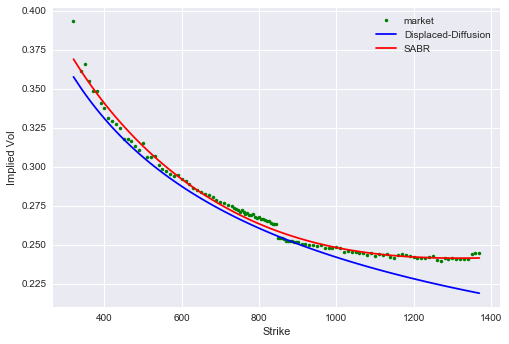

In [32]:
# plot volatility smile of market, Displaced-Diffusion Model, and SABR Model
plt.style.use('seaborn')
fig,ax=plt.subplots()
plt.plot(mkt_df['strike'],mkt_df['implied vol'],'g.',label='market')
plt.plot(mkt_df['strike'],mkt_df['DDvol'],'b-',label='Displaced-Diffusion')    
plt.plot(mkt_df['strike'],mkt_df['SABRvol'],'r-',label='SABR')

plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.legend()
plt.show()

In [33]:
x=[np.append(np.linspace(0.1,0.9,5),DDbeta)]
print(x)

[array([0.1       , 0.3       , 0.5       , 0.7       , 0.9       ,
       0.33686829])]


In [34]:
# plot: comparison of volatility smile with different beta of Displaced-Diffusion Model

betaprice=[]
for j in np.append(np.linspace(0.1,0.9,5),DDbeta):
    a=[]
    for i in range(mkt_df.shape[0]):
        if mkt_df['strike'][i]<S:
            a.append(DDPut(F,mkt_df['strike'][i],r,mkt_df['DDvol'][i],T,j))
        else:
            a.append(DDCall(F,mkt_df['strike'][i],r,mkt_df['DDvol'][i],T,j))
    betaprice.append(a)

DDbetaprice=pd.DataFrame(betaprice,index=np.append(np.linspace(0.1,0.9,5),DDbeta)).T
print(DDbetaprice.head())

vol=[]
for j in np.append(np.linspace(0.1,0.9,5),DDbeta):
    b=[]
    for i in range(mkt_df.shape[0]):
        if mkt_df['strike'][i]<S:
            b.append(impliedPutVolatility(S,mkt_df['strike'][i],r,DDbetaprice.loc[i,j],T))
        else:
            b.append(impliedCallVolatility(S,mkt_df['strike'][i],r,DDbetaprice.loc[i,j],T))
    vol.append(b)

DDbetavol=pd.DataFrame(vol,index=np.append(np.linspace(0.1,0.9,5),DDbeta)).T
print(DDbetavol.head())

    0.100000  0.300000  0.500000  0.700000  0.900000  0.336868
0   9.377566  6.720760  4.424018  2.561939  1.202196  6.268101
1   9.805025  7.180246  4.877027  2.964856  1.510896  6.729469
2  10.058333  7.445309  5.135395  3.195533  1.692183  6.994772
3  10.338772  7.735151  5.416672  3.447715  1.893749  7.284472
4  10.647081  8.050851  5.722243  3.723054  2.117487  7.599706
   0.100000  0.300000  0.500000  0.700000  0.900000  0.336868
0  0.552436  0.513669  0.472843  0.429460  0.382675  0.506309
1  0.527087  0.491694  0.454479  0.415036  0.372696  0.484980
2  0.515359  0.481522  0.445971  0.408341  0.368037  0.475106
3  0.504200  0.471840  0.437869  0.401957  0.363576  0.465707
4  0.493566  0.462612  0.430143  0.395862  0.359301  0.456748


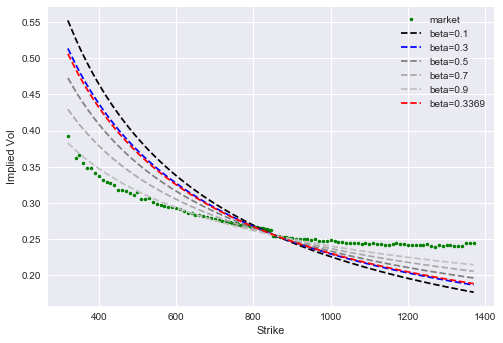

In [35]:
# plot
fig,ax=plt.subplots()
colorDD=['black','blue','grey','darkgray','silver','red']
plt.plot(mkt_df['strike'],mkt_df['implied vol'],'g.',label='market')
for i,j in enumerate(np.append(np.linspace(0.1,0.9,5),DDbeta)):
    plt.plot(mkt_df['strike'],DDbetavol[j],linestyle='--',color=colorDD[i],
                label='beta='+str(round(j,4)))

plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.legend()
plt.show()

   -0.283859   0.000000   0.283859
0   0.368916   0.340394   0.304624
1   0.361161   0.333714   0.299279
2   0.357466   0.330554   0.296787
3   0.353883   0.327506   0.294410
4   0.350407   0.324565   0.292141


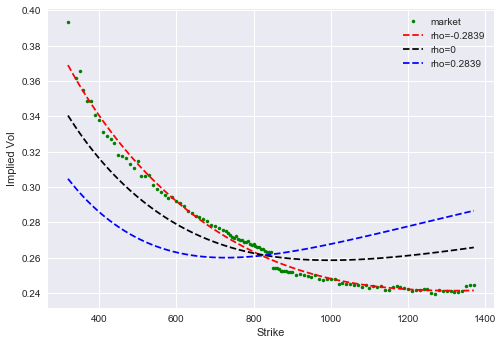

In [36]:
# plot: comparison of volatility smile with different rho of SABR Model
rho=[]
for i in [SABRrho,0,-SABRrho]:
    c=[]
    for j in range(mkt_df.shape[0]):
        c.append(SABR(F, mkt_df['strike'][j], T, SABRalpha, SABRbeta, i, SABRnu))
    rho.append(c)    
    
SABRrhovol=pd.DataFrame(rho,index=[SABRrho,0,-SABRrho]).T
print(SABRrhovol.head())
        
fig,ax=plt.subplots()
colorSABR1=['red','black','blue']
plt.plot(mkt_df['strike'],mkt_df['implied vol'],'g.',label='market')
for i,j in enumerate([SABRrho,0,-SABRrho]):
    plt.plot(mkt_df['strike'],SABRrhovol[j],linestyle='--',color=colorSABR1[i],
                label='rho='+str(round(j,4)))

plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.legend()
plt.show()

   0.100000  0.300000  0.500000  0.700000  0.900000  0.353516
0  0.300634  0.352972  0.414877  0.482092  0.554603  0.368916
1  0.297673  0.346256  0.404333  0.467826  0.536594  0.361161
2  0.296266  0.343059  0.399292  0.460988  0.527947  0.357466
3  0.294904  0.339963  0.394395  0.454332  0.519522  0.353883
4  0.293585  0.336961  0.389635  0.447850  0.511305  0.350407


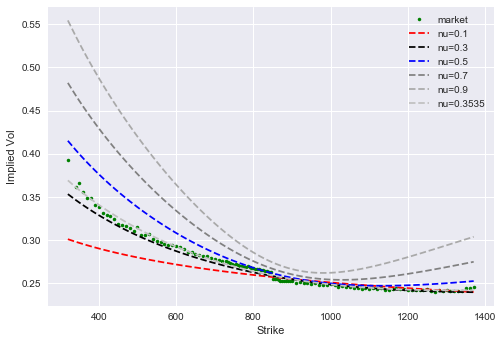

In [37]:
# plot: comparison of volatility smile with different nu of SABR Model
nu=[]
for i in np.append(np.linspace(0.1,0.9,5),SABRnu):
    d=[]
    for j in range(mkt_df.shape[0]):
        d.append(SABR(F, mkt_df['strike'][j], T, SABRalpha, SABRbeta, SABRrho, i))
    nu.append(d)    
    
SABRnuvol=pd.DataFrame(nu,index=np.append(np.linspace(0.1,0.9,5),SABRnu)).T
print(SABRnuvol.head())
        
fig,ax=plt.subplots()
colorSABR2=['red','black','blue','grey','darkgray','silver']
plt.plot(mkt_df['strike'],mkt_df['implied vol'],'g.',label='market')
for i,j in enumerate(np.append(np.linspace(0.1,0.9,5),SABRnu)):
    plt.plot(mkt_df['strike'],SABRnuvol[j],linestyle='--',color=colorSABR2[i],
                label='nu='+str(round(j,4)))

plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.legend()
plt.show()

## Part III: Static Replication

In [38]:
# Price of the derivative contract with Black-Scholes Model
def BSprice(S,sigma,r,T):
    return np.exp(-r*T)*(S**3*np.exp(3*(r+sigma**2)*T)*10**(-8)
                         +0.5*(np.log(S)+(r-sigma**2/2)*T)+10)

# Price of the derivative contract with Bachelier Model
def Bachelierprice(S,sigma,T):
    return S**3*(1+3*sigma**2*T)*10**(-8)+0.5*np.log(S)+10

print('Price with Black-Scholes Model: %.2f' %(BSprice(S,ATMimpliedvol,r,T)))
print('Price with Bachelier Model: %.2f' %(Bachelierprice(S,ATMimpliedvol,T)))

Price with Black-Scholes Model: 21.31
Price with Bachelier Model: 21.07


## Part IV: Dynamic Hedging

In [39]:
S=100
sigma=0.2
r=0.05
T=1/12 
K=100
N1=21
N2=84
paths=50_000

def simulate_Brownian_Motion(paths,steps,T,S,r,sigma):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = pd.DataFrame(np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)])
    w = np.cumsum(np.sqrt(deltaT) * X, axis=1)
    st=S*np.exp( (r-sigma**2/2)*t + sigma*w ) 
    return t, st 

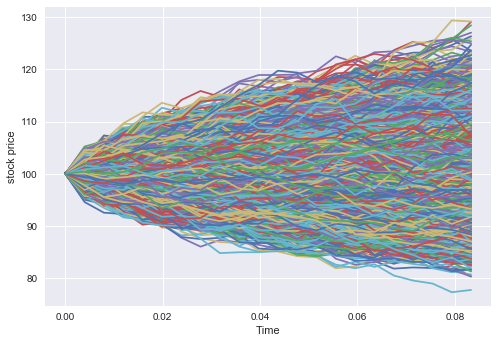

In [40]:
# plot stock price with 21 times of hedging
step1,stockprice1=simulate_Brownian_Motion(paths,N1,T,S,r,sigma)
plt.plot(step1, stockprice1.T)
plt.xlabel('Time')
plt.ylabel('stock price')
plt.show()

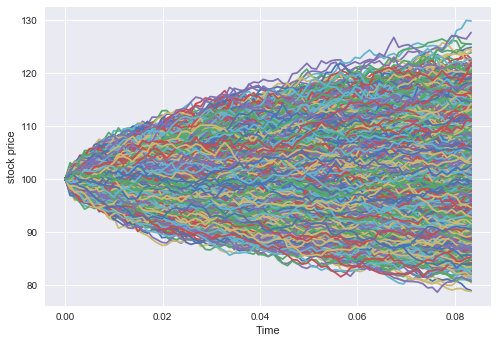

In [41]:
# plot stock price with 84 times of hedging
step2,stockprice2=simulate_Brownian_Motion(paths,N2,T,S,r,sigma)
plt.plot(step2, stockprice2.T)
plt.xlabel('Time')
plt.ylabel('stock price')
plt.show()

In [42]:
def phi_psibond(st,t,K,r,sigma,T):
    phi = norm.cdf((np.log(st/K)+(r+sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t)))
    psibond = -K*np.exp(-r*(T-t))*norm.cdf((np.log(st/K)+(r-sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t)))
    return phi, psibond

In [43]:
def HedgingStrategy(steps,phi,psibond,st,T):
    HS=pd.DataFrame()
    for i in range(steps):
        HS[i]=phi.iloc[:,i]*st.diff(axis=1).iloc[:,i+1] + psibond.iloc[:,i]*r*(T/steps)
    return HS

In [44]:
def HedgingError(paths,steps,T,S,r,sigma,K):
    t,st = simulate_Brownian_Motion(paths, steps, T, S, r, sigma)
    phi, psibond = phi_psibond(st,t,K,r,sigma,T)
    long_stock=pd.DataFrame(phi)
    short_bond=pd.DataFrame(psibond)
    Hedging = pd.DataFrame(HedgingStrategy(steps,long_stock,short_bond,st,T))
    payoff=pd.DataFrame(np.maximum(st-K,0))
    call=BlackScholesCall(S, K, r, sigma, T)
    final = np.cumsum(Hedging,axis=1)[steps-1] - payoff[steps] + call
    return final

In [45]:
print(HedgingError(paths,N1,T,S,r,sigma,K))

0        0.310102
1        0.592422
2        0.286968
3        0.103641
4       -0.350587
5       -0.127921
6       -0.504299
7       -0.311359
8       -0.989481
9       -0.109729
10      -0.575691
11      -0.099727
12      -0.148649
13      -0.575160
14       0.071630
15       0.159078
16      -0.425425
17       0.493633
18       0.029281
19       0.130273
20       0.093278
21       0.078388
22       0.767837
23       0.550303
24      -0.013985
25      -0.199083
26      -0.226610
27       0.042126
28       0.706747
29      -0.666244
           ...   
49970    0.441079
49971    0.103703
49972   -0.373836
49973    0.391360
49974   -0.324681
49975    0.160838
49976   -0.101599
49977   -0.352152
49978    0.622034
49979    0.065658
49980   -0.607343
49981   -1.061157
49982   -0.398137
49983   -0.013467
49984    0.262751
49985    0.288463
49986   -0.200020
49987    0.443376
49988   -0.149734
49989    0.647071
49990    0.002598
49991   -0.106659
49992    0.017101
49993    0.179637
49994    0

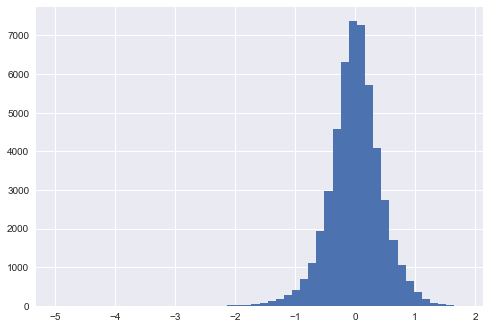

In [46]:
# plot histogram with 21 times of hedging
plt.hist(HedgingError(paths,N1,T,S,r,sigma,K),bins=50)
plt.show()

In [47]:
print(HedgingError(paths,N2,T,S,r,sigma,K))

0        0.206276
1       -0.189982
2        0.124499
3       -0.046849
4        0.014600
5        0.017679
6       -0.481436
7       -0.338569
8       -0.280463
9       -0.032159
10       0.237454
11       0.071686
12      -0.066897
13       0.399679
14       0.225355
15      -0.091591
16       0.087787
17       0.124919
18       0.090413
19      -0.296076
20      -0.035891
21      -0.171463
22       0.087365
23      -0.170855
24      -0.105508
25       0.108759
26       0.426927
27       0.068958
28      -0.225407
29      -0.140296
           ...   
49970    0.102019
49971   -0.400404
49972    0.250920
49973   -0.228418
49974   -0.384629
49975   -0.133314
49976   -0.078765
49977    0.209911
49978   -0.424481
49979    0.378788
49980   -0.230236
49981    0.079815
49982   -0.000487
49983   -0.005276
49984   -0.090911
49985   -0.385636
49986   -0.280855
49987   -0.112292
49988    0.051169
49989   -0.176376
49990   -0.237437
49991   -0.292598
49992    0.215732
49993   -0.219800
49994   -0

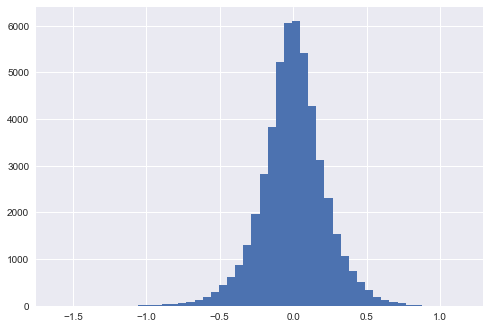

In [48]:
# plot histogram with 84 times of hedging
plt.hist(HedgingError(paths,N2,T,S,r,sigma,K),bins=50)
plt.show()